Trying to reimplement https://github.com/huggingface/transformers/blob/main/examples/research_projects/visual_bert/demo.ipynb 

In [1]:
from IPython.display import Image, display
import PIL.Image
import io
import torch
import numpy as np
from processing_image import Preprocess
from visualizing_image import SingleImageViz
from modeling_frcnn import GeneralizedRCNN
from utils import Config
import utils
from transformers import VisualBertForQuestionAnswering, BertTokenizerFast

In [2]:
%load_ext autoreload
%autoreload 2


In [3]:
# URL = "https://datasets-server.huggingface.co/assets/Maysee/tiny-imagenet/--/Maysee--tiny-imagenet/train/2/image/image.jpg"
# URL = "https://datasets-server.huggingface.co/assets/cifar100/--/cifar100/train/0/img/image.jpg"
# URL = "./input.jpg"
URL = "https://raw.githubusercontent.com/airsplay/py-bottom-up-attention/master/demo/data/images/input.jpg"
# URL = "https://vqa.cloudcv.org/media/test2014/COCO_test2014_000000262567.jpg"
OBJ_URL = "https://raw.githubusercontent.com/airsplay/py-bottom-up-attention/master/demo/data/genome/1600-400-20/objects_vocab.txt"
ATTR_URL = "https://raw.githubusercontent.com/airsplay/py-bottom-up-attention/master/demo/data/genome/1600-400-20/attributes_vocab.txt"
VQA_URL = "https://dl.fbaipublicfiles.com/pythia/data/answers_vqa.txt"

In [4]:
# for visualizing output
def showarray(a, fmt="jpeg"):
    a = np.uint8(np.clip(a, 0, 255))
    f = io.BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

In [5]:
# load object, attribute, and answer labels

objids = utils.get_data(OBJ_URL)
attrids = utils.get_data(ATTR_URL)
vqa_answers = utils.get_data(VQA_URL)

In [6]:
frcnn_cfg = Config.from_pretrained("unc-nlp/frcnn-vg-finetuned")
image_preprocess = Preprocess(frcnn_cfg)
images, sizes, scales_yx = image_preprocess(URL)

loading configuration file cache


In [ ]:
# load models and model components
frcnn_cfg = Config.from_pretrained("unc-nlp/frcnn-vg-finetuned")

frcnn = GeneralizedRCNN.from_pretrained("unc-nlp/frcnn-vg-finetuned", config=frcnn_cfg)

image_preprocess = Preprocess(frcnn_cfg)

bert_tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
visualbert_vqa = VisualBertForQuestionAnswering.from_pretrained("uclanlp/visualbert-vqa")

loading configuration file cache
loading weights file https://cdn.huggingface.co/unc-nlp/frcnn-vg-finetuned/pytorch_model.bin from cache at /root/.cache/torch/transformers/57f6df6abe353be2773f2700159c65615babf39ab5b48114d2b49267672ae10f.77b59256a4cf8343ae0f923246a81489fc8d82f98d082edc2d2037c977c0d9d0


/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


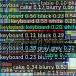

In [10]:
# image viz
frcnn_visualizer = SingleImageViz(URL, id2obj=objids, id2attr=attrids)
# run frcnn
images, sizes, scales_yx = image_preprocess(URL)
output_dict = frcnn(
    images,
    sizes,
    scales_yx=scales_yx,
    padding="max_detections",
    max_detections=frcnn_cfg.max_detections,
    return_tensors="pt",
)
# add boxes and labels to the image

frcnn_visualizer.draw_boxes(
    output_dict.get("boxes"),
    output_dict.pop("obj_ids"),
    output_dict.pop("obj_probs"),
    output_dict.pop("attr_ids"),
    output_dict.pop("attr_probs"),
)
showarray(frcnn_visualizer._get_buffer())

In [11]:
# test_questions_for_url1 = [
#     "Where is this scene?",
#     "what is the man riding?",
#     "What is the man wearing?",
#     "What is the color of the horse?"
# ]

test_questions_for_url1 = [
    "What color is the animal?"
]

features = output_dict.get("roi_features")


In [12]:
for test_question in test_questions_for_url1:
    test_question = [test_question]

    inputs = bert_tokenizer(
        test_question,
        padding="max_length",
        max_length=20,
        truncation=True,
        return_token_type_ids=True,
        return_attention_mask=True,
        add_special_tokens=True,
        return_tensors="pt",
    )

    output_vqa = visualbert_vqa(
        input_ids=inputs.input_ids,
        attention_mask=inputs.attention_mask,
        visual_embeds=features,
        visual_attention_mask=torch.ones(features.shape[:-1]),
        token_type_ids=inputs.token_type_ids,
        output_attentions=False,
    )
    # get prediction
    pred_vqa = output_vqa["logits"].argmax(-1)
    print("Question:", test_question)
    print("prediction from VisualBert VQA:", vqa_answers[pred_vqa])

Question: ['What color is the animal?']
prediction from VisualBert VQA: white
